This notebook only makes a figure out of pre-computed behavior predictions.
It relies on finding a summary file in the `results` folder.

To recompute ad reproduce these results from scratch, one would need to run the following scripts:
1. `./scripts/chewie/extract_data.py` to save the ground truth data
2. `./scripts/chewie/run_biRNN_decoder.py` to save the results of the biRNN decoder 
3. `./scripts/chewie/run_avg_per_epoch.py` to save the trial-average per-condition predictions
4. `./scripts/chewie/run_PSID.py` to save the results of the PSID decoder
5. `./scripts/chewie/run_CEBRA.py` to save the results of the CEBRA decoder
6. Run LFADS/BAND training, ablate controls, run `scripts/band_performance.py` afterwards to save each run to a summary table (see `./scripts/run_sequence.py` as an example of all actions and naming that automatically goes into summary)

In [16]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from plot_helpers import get_trials2plot, get_random_trials2plot

from lfads_torch.metrics import r2_score

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [17]:
path = '../../results/Chewie_CO_FF_2016-10-07.h5'
# path = '../../results/Mihili_CO_FF_2014-02-17.h5'
data = {}
with h5py.File(path, 'r') as f:
   for key in f.keys():
      data[key] = f[key][()]
data.keys()

dict_keys(['test_M1_MUA_birnn_pred', 'test_M1_band_100f_4c_pred', 'test_M1_band_10f_2c_pred', 'test_M1_band_10f_2c_sample1_pred', 'test_M1_band_10f_2c_sample2_pred', 'test_M1_band_10f_2c_sample3_pred', 'test_M1_band_10f_2c_sample4_pred', 'test_M1_band_12f_2c_pred', 'test_M1_band_12f_2c_sample1_pred', 'test_M1_band_12f_2c_sample2_pred', 'test_M1_band_12f_2c_sample3_pred', 'test_M1_band_12f_2c_sample4_pred', 'test_M1_band_14f_2c_pred', 'test_M1_band_14f_2c_sample1_pred', 'test_M1_band_14f_2c_sample2_pred', 'test_M1_band_14f_2c_sample3_pred', 'test_M1_band_14f_2c_sample4_pred', 'test_M1_band_16f_2c_pred', 'test_M1_band_16f_2c_sample1_pred', 'test_M1_band_16f_2c_sample2_pred', 'test_M1_band_16f_2c_sample3_pred', 'test_M1_band_16f_2c_sample4_pred', 'test_M1_band_32f_2c_pred', 'test_M1_band_32f_2c_sample1_pred', 'test_M1_band_32f_2c_sample2_pred', 'test_M1_band_4f_2c_pred', 'test_M1_band_4f_2c_sample1_pred', 'test_M1_band_4f_2c_sample2_pred', 'test_M1_band_64f_2c_pred', 'test_M1_band_64f_2c_

<IPython.core.display.Javascript object>

In [18]:
dset='valid'
vel = data[f'{dset}_behavior'][:]
target_direction = data[f'{dset}_target_direction'][:]
epoch = data[f'{dset}_epoch'][:]
pos = np.cumsum(vel, axis=1)

<IPython.core.display.Javascript object>

In [19]:
dir_index = np.array([
        sorted(set(target_direction)).index(i) for i in target_direction
    ])

avg_vel_per_epoch = data['test_all_avg_per_epoch_pred']


<IPython.core.display.Javascript object>

In [20]:
np.random.seed(1)
# trials2plot = np.array([get_random_trials2plot(vel, avg_vel_per_epoch, dir_index, epoch, i) for i in range(3)]).sum(0)
trials2plot = np.array([get_random_trials2plot(dir_index, epoch, i) for i in range(3)]).sum(0)
trials2plot.sum()

24

<IPython.core.display.Javascript object>

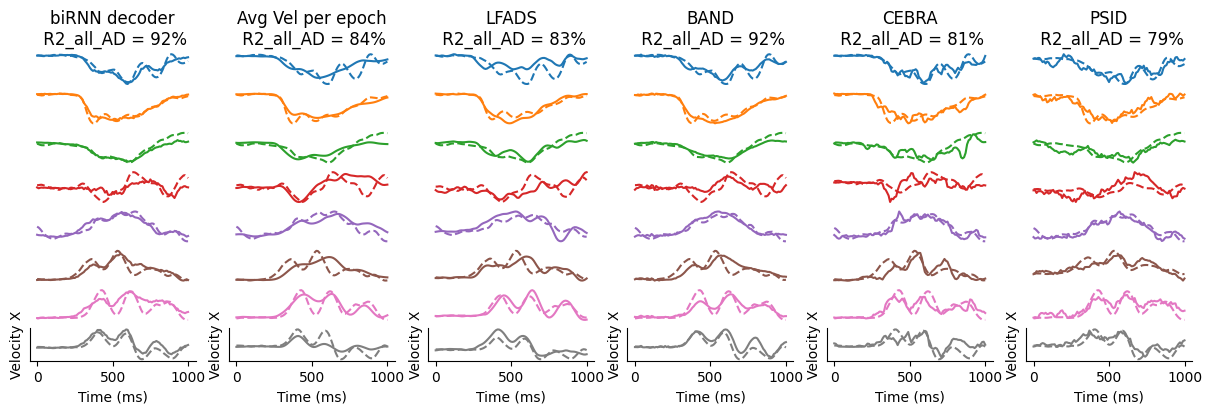

<IPython.core.display.Javascript object>

In [21]:
def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''

    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                axes[d].plot(
                    time,
                    v[t, :, component],
                    color=f"C{d}",
                    alpha=1,
                    ls=ls,
                )

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    axes[-1].set_ylabel("Velocity X")

    R2_iso_vel = r2_score(pred_vel,vel)
    axes[0].set_title(f'{title}\n R2_{area}_{epoch_name} = {R2_iso_vel*100:.0f}%')
        

fig, axes = plt.subplots(8,6,figsize=(6*2.5, 8*.5))

# epoch_mask, epoch_name = (epoch==0), 'BL'
epoch_mask, epoch_name = (epoch==1), 'AD'
# epoch_mask, epoch_name = (epoch==epoch), 'all'
component = 0

area = 'all'
for i, (key, title) in enumerate(zip([f'test_{area}_birnn_pred','test_all_avg_per_epoch_pred',
                                      f'test_{area}_lfads_100f_4c_pred',f'test_{area}_band_100f_4c_pred',
                                      f'test_{area}_cebra_pred',f'test_{area}_psid_pred'],
                                  ['biRNN decoder', 'Avg Vel per epoch',
                                   'LFADS', 'BAND',
                                   'CEBRA',"PSID"])):

    plot_beh_pred(vel[epoch_mask], 
                data[key][epoch_mask], 
                dir_index[epoch_mask], 
                trials2plot[epoch_mask], 
                axes[:,i], 
                area,
                epoch_name,
                component=1, 
                title=title)

fig.savefig("figs/Figure4")

Text(0.5, 1.0, 'Chewie_CO_FF_2016-10-07')

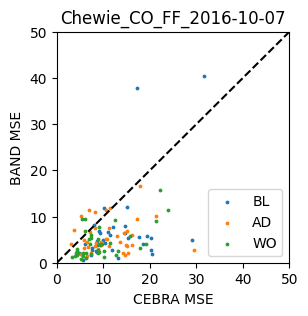

<IPython.core.display.Javascript object>

In [22]:
mse_cebra = np.mean((data[f'test_{area}_cebra_pred'] - vel) ** 2,-1).mean(-1)
mse_band = np.mean((data[f'test_{area}_band_pred'] - vel) ** 2,-1).mean(-1)
plt.figure(figsize=(3,3))
for e, en in enumerate(['BL','AD','WO']):
    mask = epoch==e
    plt.scatter(mse_cebra[mask], mse_band[mask],s=3,label=en)
plt.legend()
plt.xlim([0,50])
plt.ylim([0,50])
plt.plot([0,50],[0,50],'k--')
plt.xlabel('CEBRA MSE')
plt.ylabel('BAND MSE')
plt.title(path.split('/')[-1].split('.')[0])

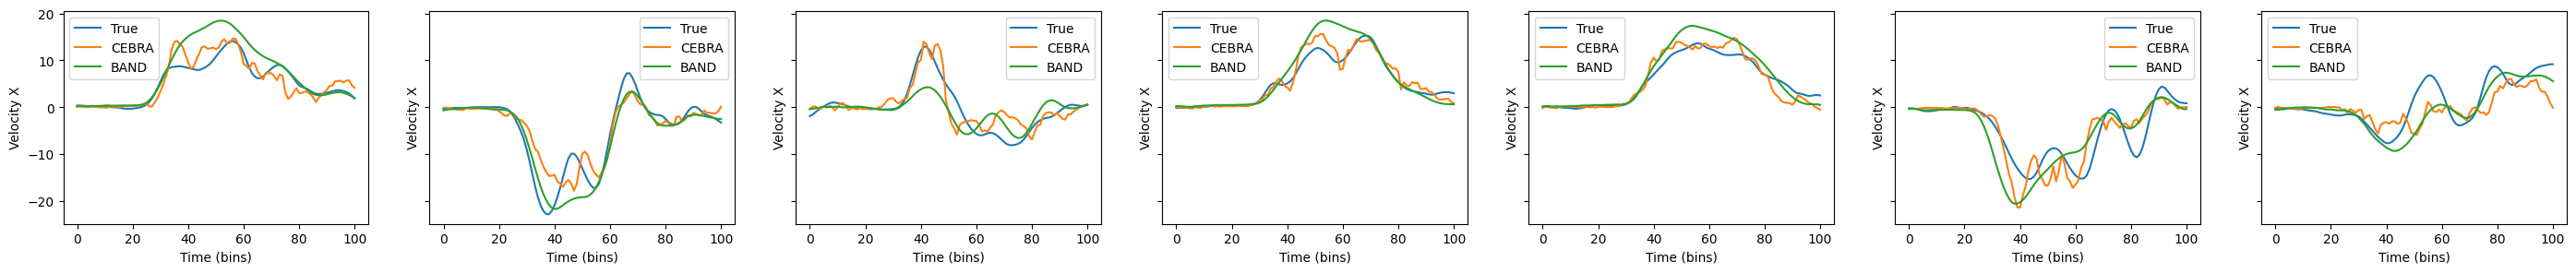

<IPython.core.display.Javascript object>

In [23]:
mask = (mse_band<20) & (mse_cebra<mse_band) & (epoch == 1)

fig, axes = plt.subplots(1,sum(mask),figsize=(sum(mask)*5, 3),sharey=True)
for i,m in enumerate(np.where(mask)[0]):
    axes[i].plot(vel[m,:,0].T,label='True')
    axes[i].plot(data[f'test_{area}_cebra_pred'][m,:,0].T,label='CEBRA')
    axes[i].plot(data[f'test_{area}_band_pred'][m,:,0].T,label='BAND')
    # axes[i].plot(data[f'test_{area}_birnn_pred'][m,:,0].T,label='biRNN')
    axes[i].legend()
    axes[i].set_xlabel('Time (bins)')
    axes[i].set_ylabel('Velocity X')

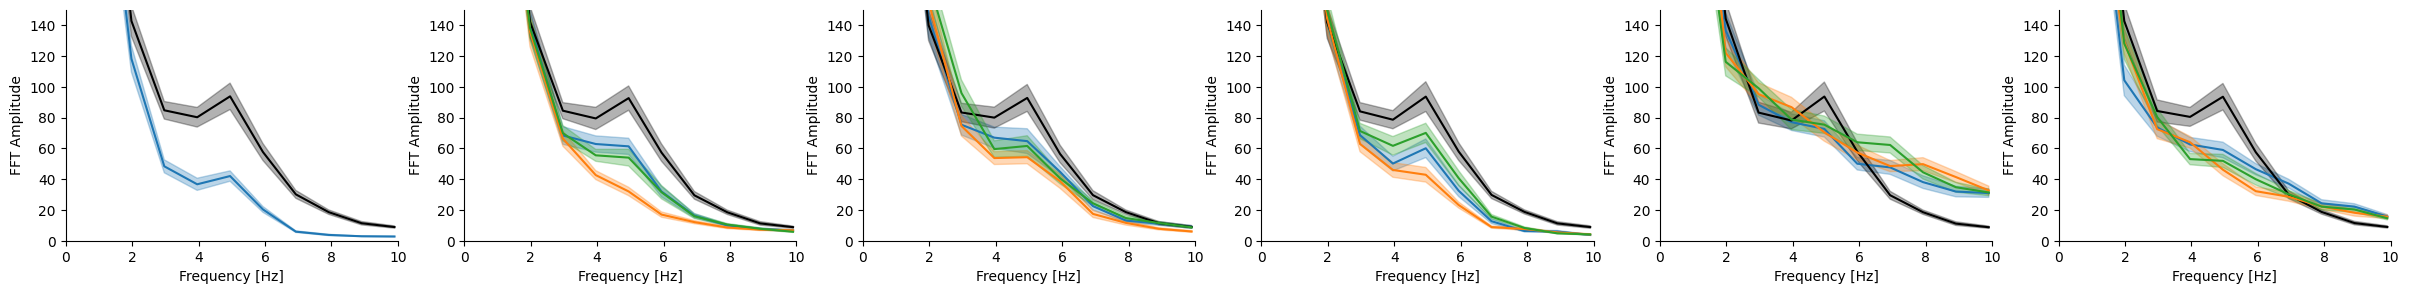

<IPython.core.display.Javascript object>

In [24]:
from scipy.fftpack import fft, fftfreq

def plot_fourier(ax, V, dt=0.01, label='', c='k', linestyle='solid'):

        SR = []
        for _ in range(100):

            idxs = np.random.choice(V.shape[0], V.shape[0], replace=True)

            x = V[idxs]

            xf = fft(x)  # Compute Fourier transform of x
            Sxx_all = (xf * xf.conj()).real # Compute power spectrum

            SR.append(np.sqrt(Sxx_all).mean(0))

        faxis = fftfreq(Sxx_all.shape[1]) / dt  # Construct frequency axis
        SR = np.asarray(SR)

        mask = (faxis > 0) & (faxis <= 10)
        ax.plot(
            faxis[mask],
            SR.mean(0)[mask],c=c, label=label, linestyle=linestyle)
        
        ax.fill_between(
            faxis[mask],
            SR.mean(0)[mask] - SR.std(0)[mask],
            SR.mean(0)[mask] + SR.std(0)[mask],
            alpha=0.3, color=c
        )

        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('FFT Amplitude')
        ax.set_ylim([0,150])
        ax.set_xlim([0,10])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

fig, axes = plt.subplots(1,6,figsize=(6*5, 3))

epoch_mask, epoch_name = (epoch==1), 'AD'
component = 0 # velocity X

colors = {'all': 'C0', "PMd": 'C1', "M1": 'C2'}
for area in ['all', 'PMd', 'M1']:
    label = area
    for i, key in enumerate(['test_all_avg_per_epoch_pred', f'test_{area}_birnn_pred',
                                        f'test_{area}_lfads_100f_4c_pred',f'test_{area}_band_100f_4c_pred',
                                        f'test_{area}_cebra_pred',f'test_{area}_psid_pred'],
                                    ):
        if i==0:
            if area == 'all':
                plot_fourier(axes[i], data[key][epoch_mask][...,component], dt=0.01, label='trial avg', c=colors[area])
        else:
            plot_fourier(axes[i], data[key][epoch_mask][...,component], dt=0.01, label=label, c=colors[area])
        if area == 'all':
            plot_fourier(axes[i], vel[epoch_mask][...,component], dt=0.01, label='true velocity X', c='k')

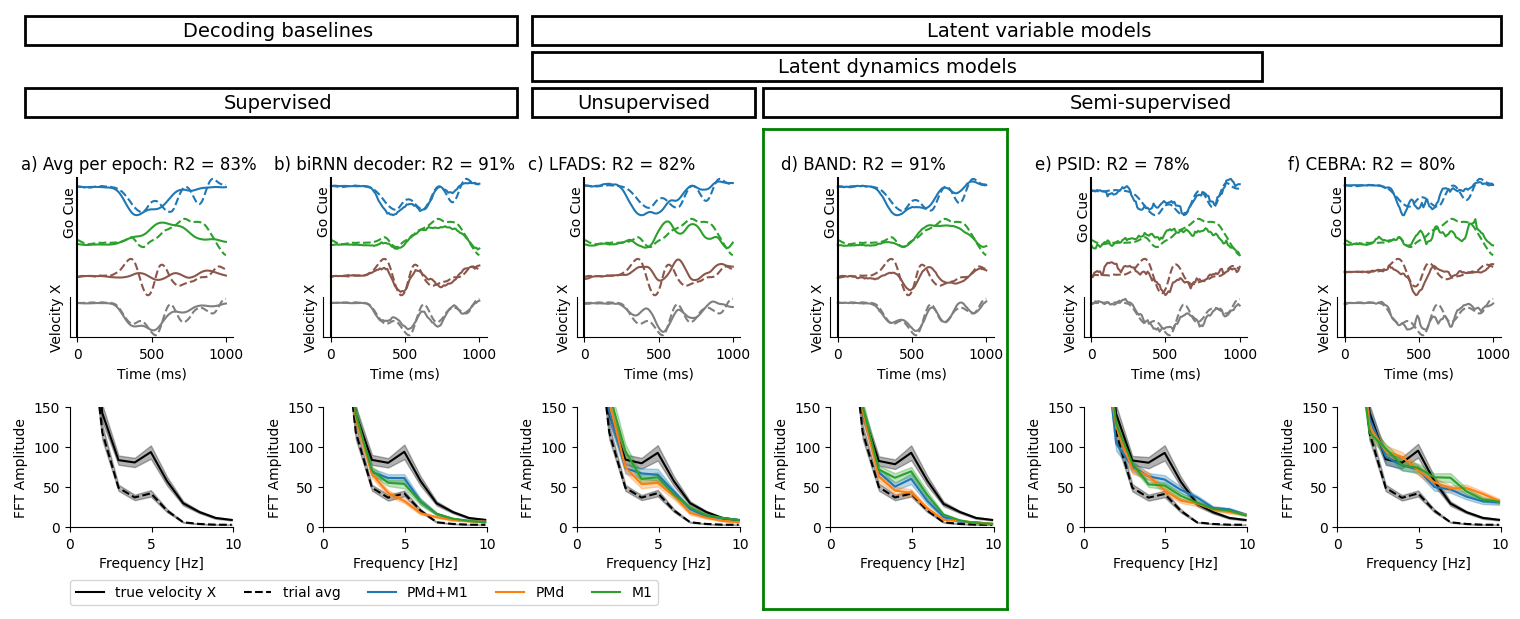

<IPython.core.display.Javascript object>

In [86]:
def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, select = None, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''
    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                if select is None:
                    d_id = d
                else:
                    if d in select:
                        d_id = np.where(select == d)[0][0]
                    else: 
                        d_id = None
                if d_id is not None:
                    axes[d_id].plot(
                        time,
                        v[t, :, component],
                        color=f"C{d}",
                        alpha=1,
                        ls=ls,
                    )
    for d in range(len(axes)):
        axes[d].axvline(0,c='k')

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    component_names = ['Velocity X', 'Velocity Y']
    axes[-1].set_ylabel(component_names[component])
    axes[0].text(0,0,'Go Cue',rotation=90,va='top',ha='right')

    R2_iso_vel = 1 - np.sum((vel - pred_vel) ** 2) / np.sum((vel - vel.mean(0)) ** 2)
    if component == 0:
        
        ttl = axes[0].set_title(f'{title}: R2 = {R2_iso_vel*100:.0f}%',loc='left')
        ttl.set_position([-.3, 1.1])
    # R2_iso_vel = 1 - np.sum((vel[t2p == 1] - pred_vel[t2p == 1]) ** 2) / np.sum((vel[t2p == 1] - vel.mean(0)) ** 2)
    # axes[0].set_title(f'{title}\n R2_{area}_{epoch_name} = {R2_iso_vel*100:.2f}%')
        

fig = plt.figure(figsize=(15, 6))
# fig.add_axes([0,0,1,1])
axes = np.empty((4,6),dtype=object)
axes_fourier = np.empty(6,dtype=object)
mx = 0.02
my = 0.08
col_width = (1-mx) / 5.8

for j in range(6):
    for i in range(4):
        axes[i,j] = fig.add_axes([2*mx + j*col_width,
                                  .8-my-(i+1)/15,
                                  (1-mx)/9,
                                  1/15])
    axes_fourier[j] = fig.add_axes([2*mx + j*col_width,
                                    .8-my-5/15 - 0.25,
                                    (1-mx)/9,
                                    .2])

band_highlight = fig.add_axes([-0.25*mx+3*col_width,
                               0,
                               2*(1-mx)/15 + 1.6*mx,
                               .8])
band_highlight.set_xticks([])
band_highlight.set_yticks([])

titles = fig.add_axes([0,0.8,1,.2])
titles.axis('off')
# draw rectangles with text
fs = 14
# Decoding baselines | Latent variable models
titles.text(.5*mx + 1*col_width,.9,'Decoding baselines',ha='center',va='top',fontsize=fs)
titles.text(.5*mx + 4*col_width,.9,'Latent variable models',ha='center',va='top',fontsize=fs)
titles.add_patch(plt.Rectangle((0.5*mx+0.,0.7),            2*col_width - 0.5*mx, 0.24, edgecolor='k', facecolor='none', lw=2))
titles.add_patch(plt.Rectangle((0.5*mx+2*col_width,0.7),   4*col_width - 1.5*mx, 0.24, edgecolor='k', facecolor='none', lw=2))
# - | Latent dynamics models | -
titles.text(0.*mx + 3.5*col_width,.6,'Latent dynamics models',ha='center',va='top',fontsize=fs)
titles.add_patch(plt.Rectangle((0.5*mx+2*col_width,0.4),   3*col_width - mx, 0.24, edgecolor='k', facecolor='none', lw=2))
# Supervised | Unsupervised | Semi-supervised
titles.text(.5*mx + 1*col_width,.3,'Supervised',ha='center',va='top',fontsize=fs)
titles.text(0.*mx + 2.5*col_width,.3,'Unsupervised',ha='center',va='top',fontsize=fs)
titles.text(0.*mx + 4.5*col_width,.3,'Semi-supervised',ha='center',va='top',fontsize=fs)
titles.add_patch(plt.Rectangle((0.5*mx+0.,0.1),            2*col_width - 0.5*mx, 0.24, edgecolor='k', facecolor='none', lw=2))
titles.add_patch(plt.Rectangle((0.5*mx+2*col_width,0.1),   1*col_width - mx, 0.24, edgecolor='k', facecolor='none', lw=2))
titles.add_patch(plt.Rectangle((-0.25*mx+3*col_width,0.1), 3*col_width - 0.75*mx, 0.24, edgecolor='k', facecolor='none', lw=2))


# make spines green and bold
for spine in band_highlight.spines.values():
    spine.set_edgecolor('g')
    spine.set_linewidth(2)
#make face disappear
band_highlight.set_facecolor('none')

# epoch_mask, epoch_name = (epoch==0), 'BL'
epoch_mask, epoch_name = (epoch==1), 'AD'
# epoch_mask, epoch_name = (epoch==epoch), 'all'
component = 0 # velocity X

area = 'all'
for i, (key, title) in enumerate(zip(['test_all_avg_per_epoch_pred', f'test_{area}_birnn_pred',
                                      f'test_{area}_lfads_100f_4c_pred',f'test_{area}_band_100f_4c_pred',
                                      f'test_{area}_psid_pred', f'test_{area}_cebra_pred'],
                                  ['a) Avg per epoch', 'b) biRNN decoder',
                                   'c) LFADS', 'd) BAND',
                                   'e) PSID', 'f) CEBRA'])):
    plot_beh_pred(vel[epoch_mask], 
                data[key][epoch_mask], 
                dir_index[epoch_mask], 
                trials2plot[epoch_mask], 
                axes[:,i], 
                area,
                epoch_name,
                select = np.array([0,2,5,7]),
                component=component, 
                title=title)


colors = {'all': 'C0', "PMd": 'C1', "M1": 'C2'}
for area in ['all','PMd', 'M1']:
    label = area
    if area == 'all':
        label = 'PMd+M1'
    for i, key in enumerate(['test_all_avg_per_epoch_pred', f'test_{area}_birnn_pred',
                                        f'test_{area}_lfads_100f_4c_pred',f'test_{area}_band_100f_4c_pred',
                                        f'test_{area}_psid_pred', f'test_{area}_cebra_pred'],
                                    ):
    
        if area == 'all':
            plot_fourier(axes_fourier[i], vel[epoch_mask][...,component], dt=0.01, label='true velocity X', c='k')
            plot_fourier(axes_fourier[i], data['test_all_avg_per_epoch_pred'][epoch_mask][...,component], dt=0.01, label='trial avg', c='k', linestyle='--')
        if i!=0:
            plot_fourier(axes_fourier[i], data[key][epoch_mask][...,component], dt=0.01, label=label, c=colors[area])
        if i == 1:
            # horizontal legend
            axes_fourier[i].legend(loc=(-1.55,-.65),ncol=5)
fig.savefig("figs/Figure4.pdf")

# Velocity components are in different phases

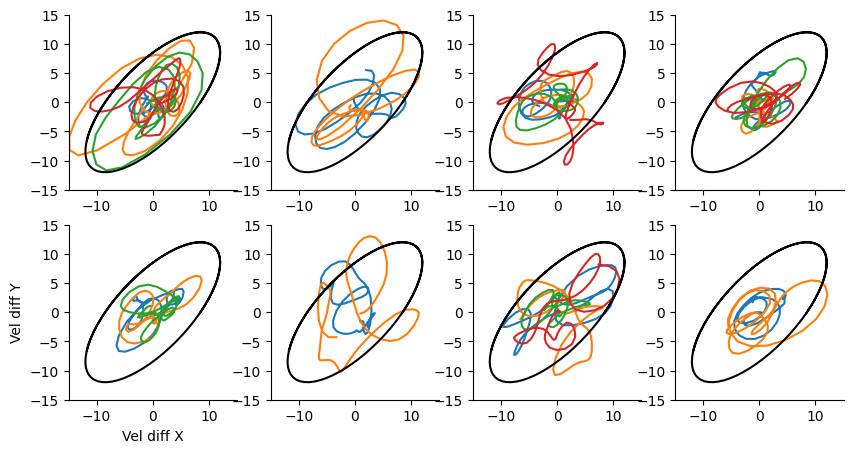

<IPython.core.display.Javascript object>

In [69]:
t=np.linspace(0,1,100)
w = 10
dummy_data = np.array([np.sin(w*t+np.pi/4), np.sin(w*t)])

vel_diff = vel[epoch_mask] - data['test_all_avg_per_epoch_pred'][epoch_mask]

fig, axes = plt.subplots(2,4, figsize=(10,5))
for e, ax in enumerate(axes.flatten()):
  for t in np.where(dir_index[epoch_mask]==e)[0][::2]:
    ax.plot(*vel_diff[t][25:].T)

  ax.set_xlim([-15,15])
  ax.set_ylim([-15,15])
  ax.plot(*dummy_data*12,'k')
  # remove right and top
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  axes[1,0].set_xlabel('Vel diff X')
  axes[1,0].set_ylabel('Vel diff Y')


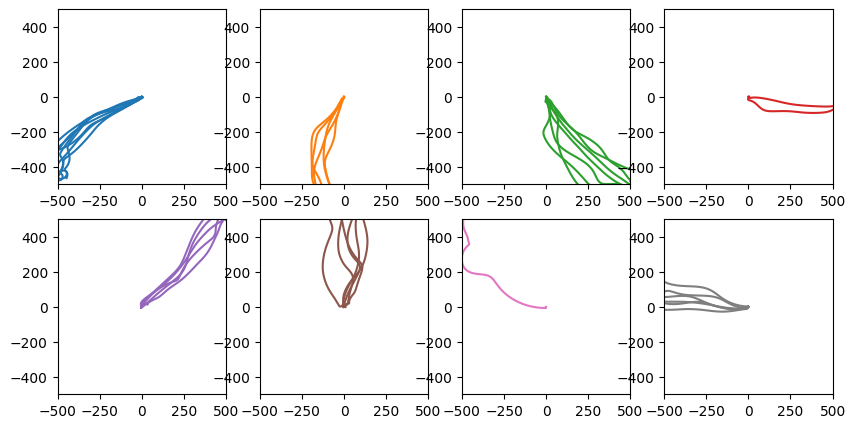

<IPython.core.display.Javascript object>

In [35]:
fig, axes = plt.subplots(2,4, figsize=(10,5))
for e, ax in enumerate(axes.flatten()):
  for t in np.where(dir_index[epoch_mask]==e)[0]:
    ax.plot(*pos[epoch_mask][t].T,c=f'C{e}')

  ax.set_xlim([-500,500])
  ax.set_ylim([-500,500])

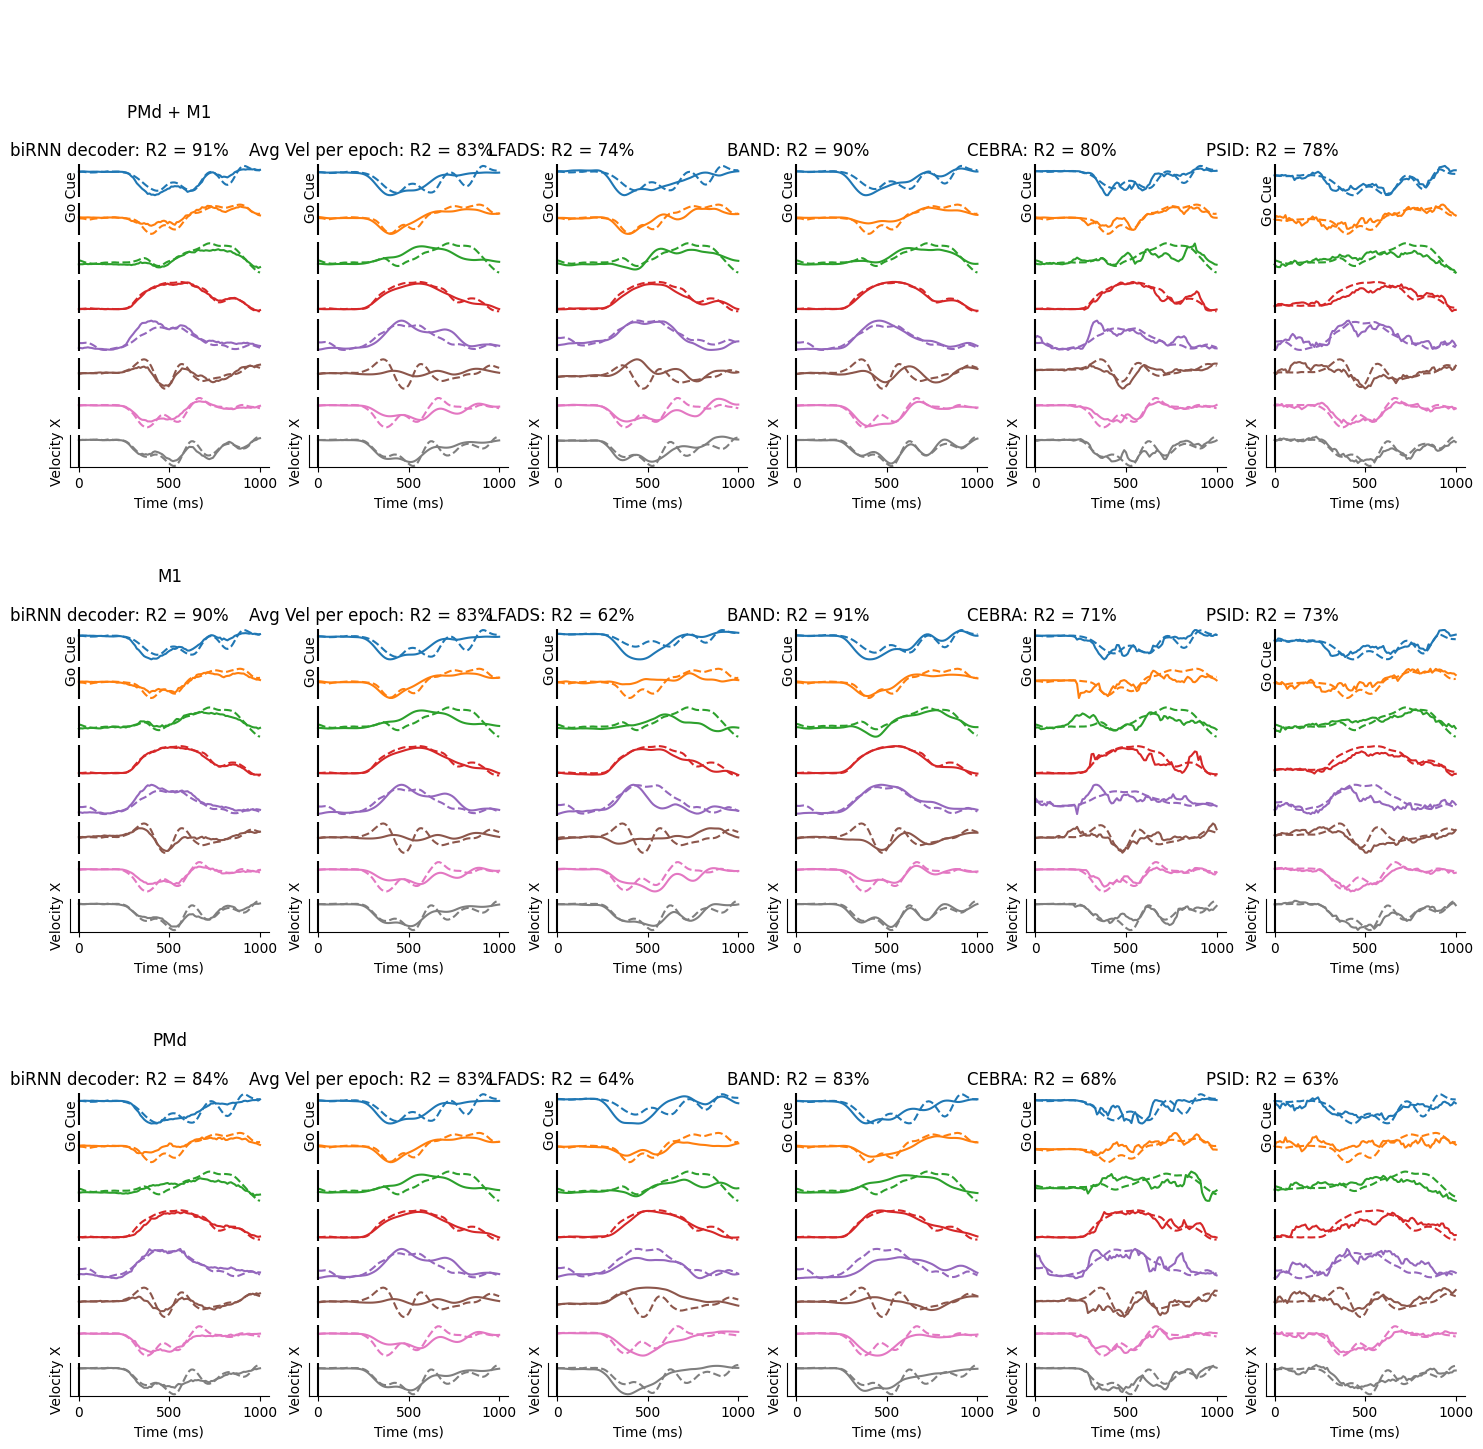

<IPython.core.display.Javascript object>

In [16]:
skip = 4
fig, axes = plt.subplots((8+skip)*3,6,figsize=(6*3, (8+skip)*.5*3))

# epoch_mask, epoch_name = (epoch==0), 'BL'
epoch_mask, epoch_name = (epoch==1), 'AD'
# epoch_mask, epoch_name = (epoch==epoch), 'all'
component = 0

# area = 'all'

import matplotlib.patches as patches
for j, area in enumerate(['all','M1','PMd']):
    model_keys = [f'test_{area}_birnn_pred','test_all_avg_per_epoch_pred',
                    f'test_{area}_lfads_pred',f'test_{area}_band_pred',
                    f'test_{area}_cebra_pred',f'test_{area}_psid_pred']
    for i, (key, title) in enumerate(zip(model_keys,
                                    ['biRNN decoder', 'Avg Vel per epoch',
                                    'LFADS', 'BAND',
                                    'CEBRA',"PSID"])):

        plot_beh_pred(vel[epoch_mask], 
                    data[key][epoch_mask], 
                    dir_index[epoch_mask], 
                    trials2plot[epoch_mask], 
                    axes[j*(8+skip)+skip:(j+1)*(8+skip),i], 
                    area,
                    epoch_name,
                    component=0, 
                    title=title)
        for k in range(skip):
            axes[j*(8+skip)+k,i].axis("off")
    if area=='all':
        area_title = 'PMd + M1'
    else:
        area_title = area
    axes[j*(8+skip)+skip-1,0].set_title(area_title)

fig.savefig("figs/Figure4_supplement.pdf")

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0]
[0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0]
[1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0]
[0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0]
[0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0]
[0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0]


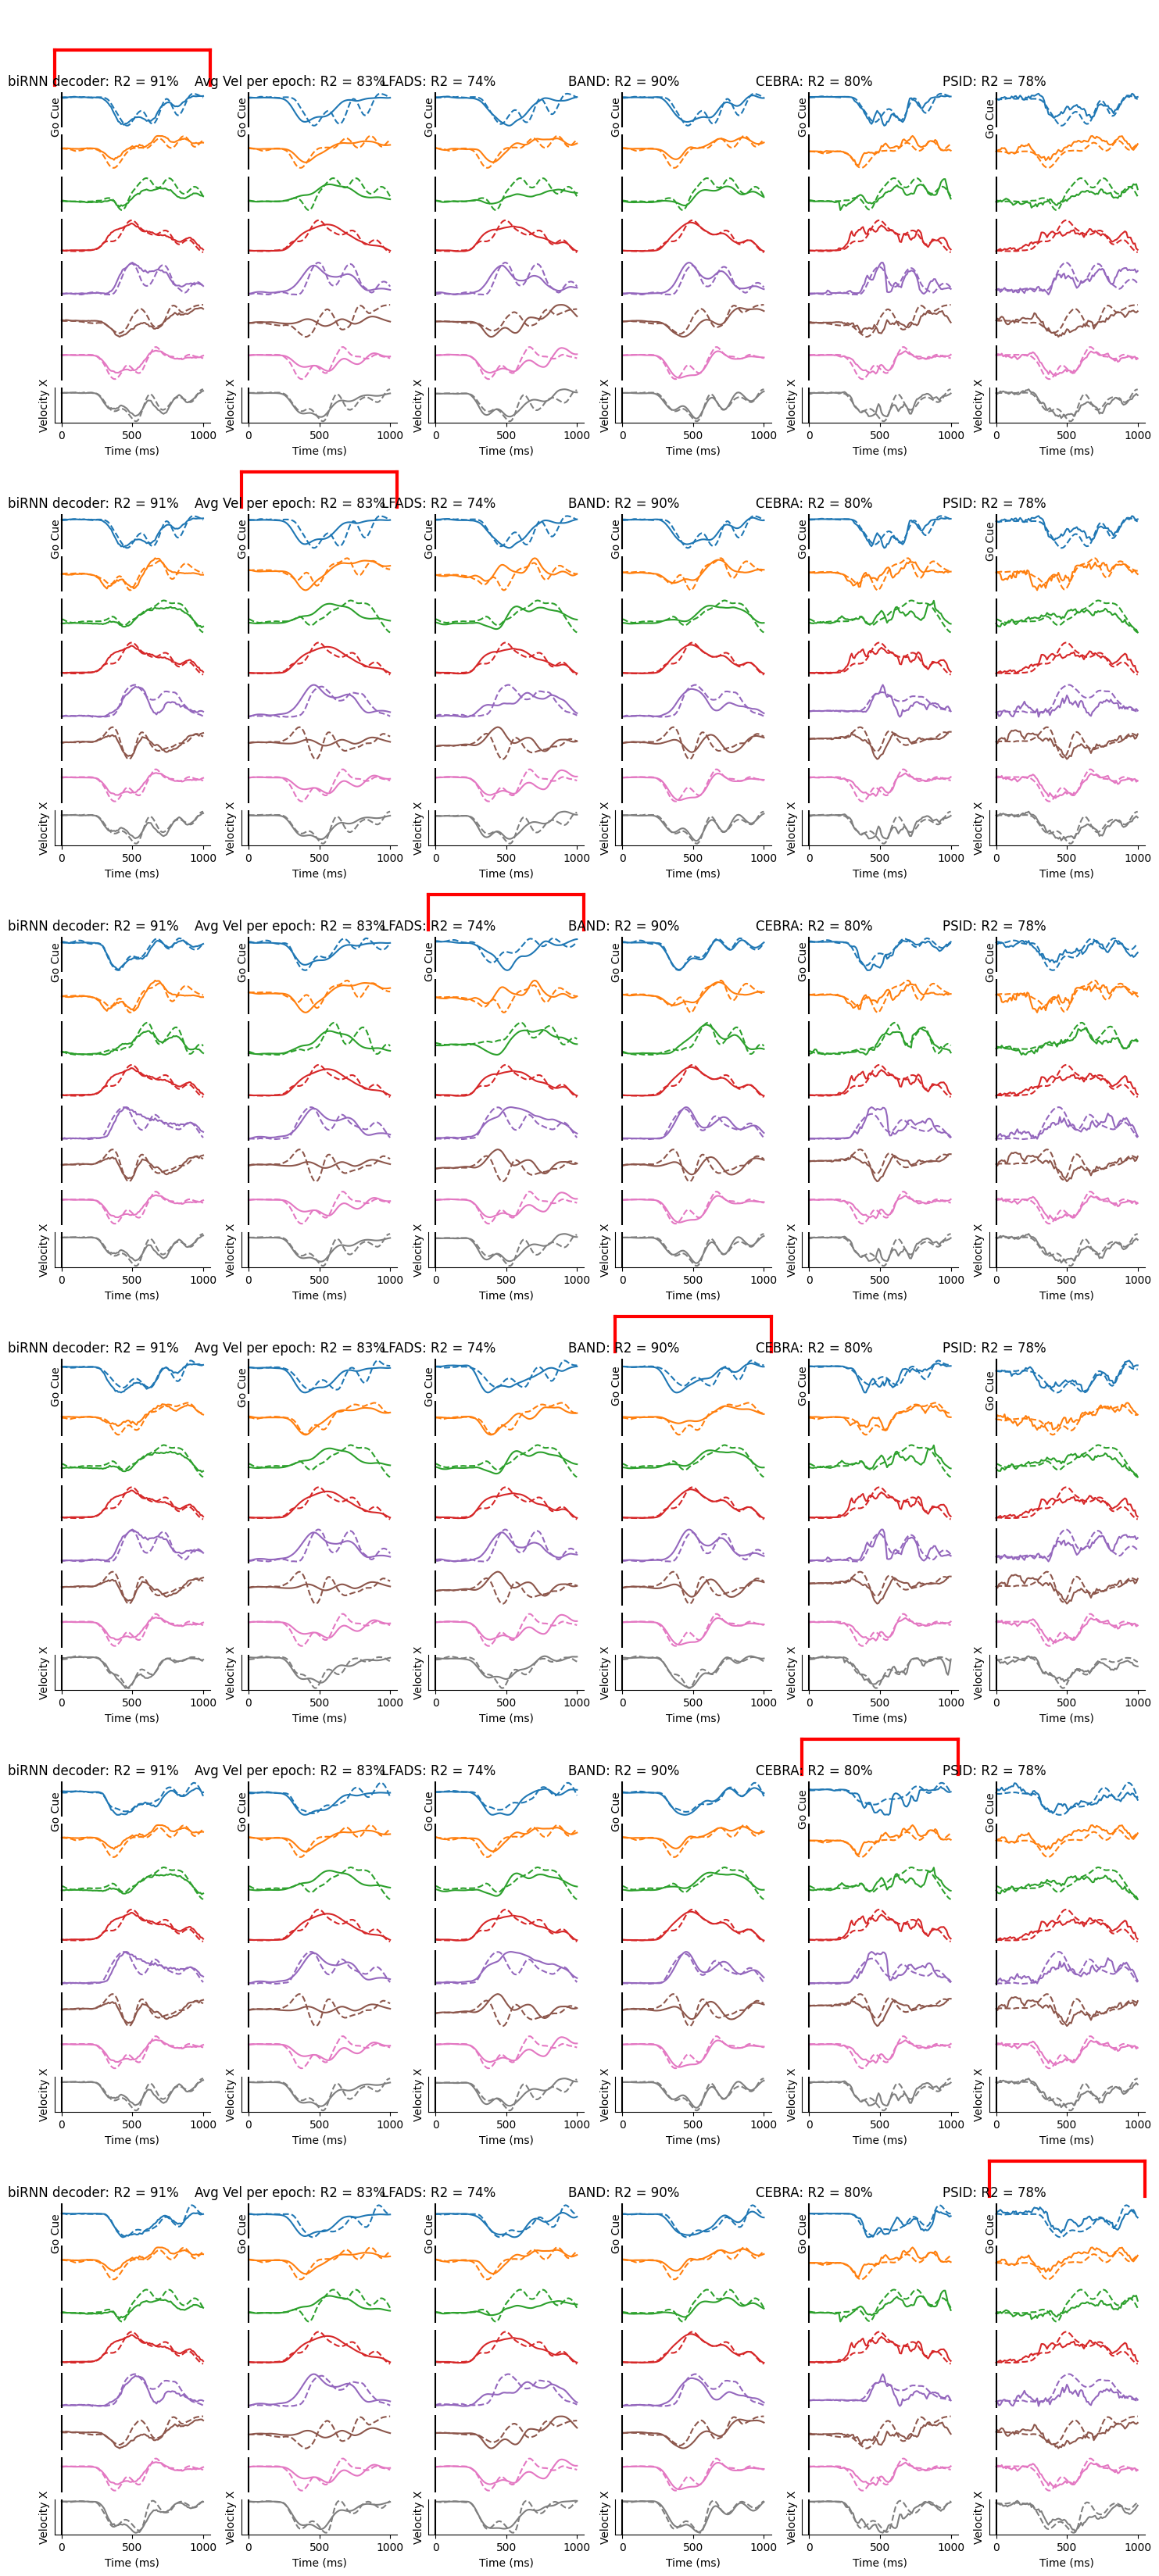

<IPython.core.display.Javascript object>

In [13]:
fig, axes = plt.subplots((8+2)*6,6,figsize=(6*3, (8+2)*.7*6))

# epoch_mask, epoch_name = (epoch==0), 'BL'
epoch_mask, epoch_name = (epoch==1), 'AD'
# epoch_mask, epoch_name = (epoch==epoch), 'all'
component = 0

area = 'all'
model_keys = [f'test_{area}_birnn_pred','test_all_avg_per_epoch_pred',
                f'test_{area}_lfads_pred',f'test_{area}_band_pred',
                f'test_{area}_cebra_pred',f'test_{area}_psid_pred']

import matplotlib.patches as patches
for j,model_key in enumerate(model_keys):
    trials2plot = np.array([get_trials2plot(vel, data[model_key], dir_index, epoch, i) for i in range(3)]).sum(0)
    print(trials2plot[epoch_mask])
    for i, (key, title) in enumerate(zip(model_keys,
                                    ['biRNN decoder', 'Avg Vel per epoch',
                                    'LFADS', 'BAND',
                                    'CEBRA',"PSID"])):

        plot_beh_pred(vel[epoch_mask], 
                    data[key][epoch_mask], 
                    dir_index[epoch_mask], 
                    trials2plot[epoch_mask], 
                    axes[j*10+2:(j+1)*10,i], 
                    area,
                    epoch_name,
                    component=0, 
                    title=title)
        axes[j*10,i].axis("off")
        axes[j*10+1,i].axis("off")
    axes[j*10+1,j].axis("on")
    for edge in ['top','left','right']:
        axes[j*10+1,j].spines[edge].set_color('red')
        axes[j*10+1,j].spines[edge].set_linewidth(3)
    axes[j*10+1,j].set_xticks([])
    axes[j*10+1,j].set_yticks([])
    axes[j*10+1,j].spines['bottom'].set_linewidth(0)



In [14]:
# loop through epochs (x3)
# loop through areas (keeping all for Avg) (x3)
# loop through components (x2)

# 18 figures in total. Paper: AD and all 3 areas, X coordinate

<IPython.core.display.Javascript object>